In [1]:
import requests
from datetime import date, timedelta
import pandas as pd

url = "https://api.coingecko.com/api/v3/coins/bitcoin/history?date="

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}


def daterange(start_date: date, end_date: date):
    days = int((end_date - start_date).days)
    for n in range(days):
        yield start_date + timedelta(n)

start_date = date(2025, 4, 1)
end_date = date(2025, 4, 14)
res = []
for single_date in daterange(start_date, end_date):
    response = requests.get(url + single_date.strftime("%d-%m-%Y") + "&localization=false", headers=headers)
    data = response.json()
    res.append({
        "date" : single_date, 
        "price" : data["market_data"]["current_price"]["usd"], 
        "total volume" : data["market_data"]["total_volume"]["usd"],
        "market cap" : data["market_data"]["market_cap"]["usd"]})

df = pd.DataFrame(res)

print(df)


          date         price  total volume    market cap
0   2025-04-01  82514.093654  3.032615e+10  1.635077e+12
1   2025-04-02  85237.587605  2.917290e+10  1.690602e+12
2   2025-04-03  82526.422153  4.633291e+10  1.637359e+12
3   2025-04-04  83163.987574  3.659446e+10  1.652537e+12
4   2025-04-05  83852.007654  3.564729e+10  1.664235e+12
5   2025-04-06  83595.885502  1.491040e+10  1.656020e+12
6   2025-04-07  78211.483582  3.614038e+10  1.555325e+12
7   2025-04-08  79179.292268  8.290975e+10  1.581408e+12
8   2025-04-09  76329.090356  4.781279e+10  1.515042e+12
9   2025-04-10  82622.170295  8.740822e+10  1.640568e+12
10  2025-04-11  79596.357323  4.121352e+10  1.580023e+12
11  2025-04-12  83439.288180  3.981357e+10  1.655869e+12
12  2025-04-13  85305.097284  2.242893e+10  1.693601e+12


                                price    return
timestamp                                      
2025-04-19 11:04:51.582  85222.967731       NaN
2025-04-19 12:04:38.460  85196.357248 -0.000312
2025-04-19 13:00:52.596  85277.070944  0.000947
2025-04-19 14:04:39.991  85450.837626  0.002038
2025-04-19 15:09:26.840  85405.397795 -0.000532
2025-04-19 16:04:54.075  85216.925511 -0.002207
2025-04-19 17:04:48.535  84884.074762 -0.003906
2025-04-19 18:04:47.543  85152.684142  0.003164
2025-04-19 19:04:57.549  85145.761088 -0.000081
2025-04-19 20:01:54.415  85081.679481 -0.000753
2025-04-19 21:04:53.819  85202.135263  0.001416
2025-04-19 22:04:51.622  85317.397984  0.001353
2025-04-19 23:04:56.247  85246.712841 -0.000828
Volatility of Bitcoin for last 24 hours:0.0019


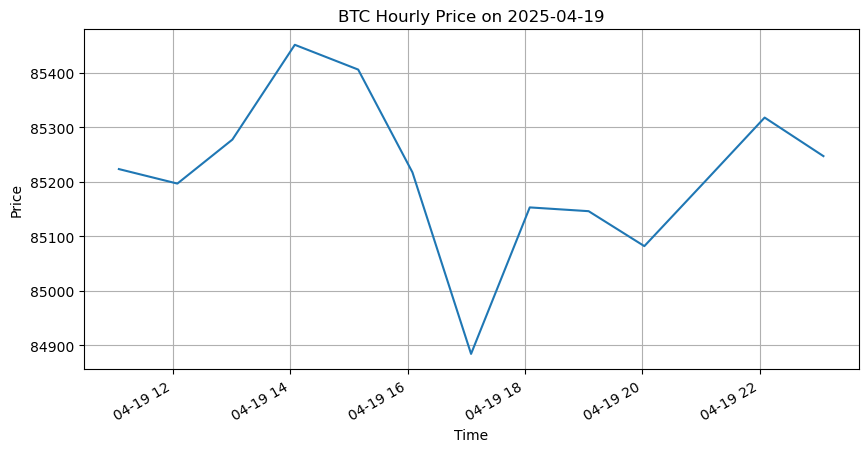

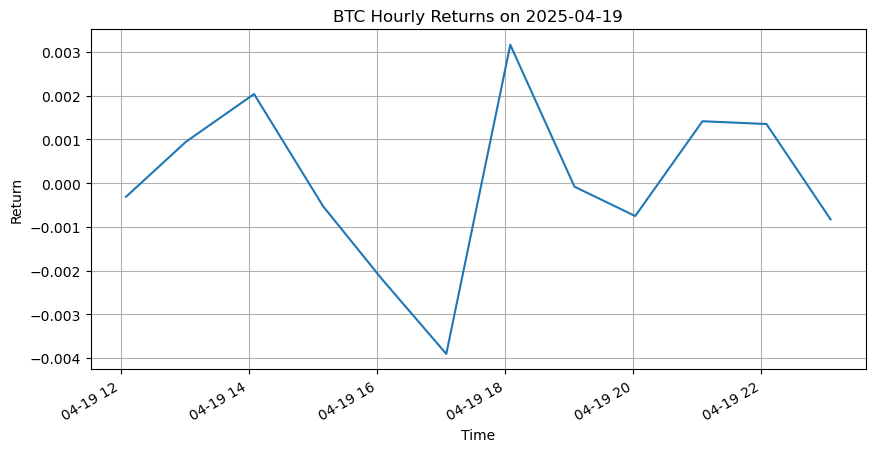

Votatility or Standard Deviation for 24h : 0.001923


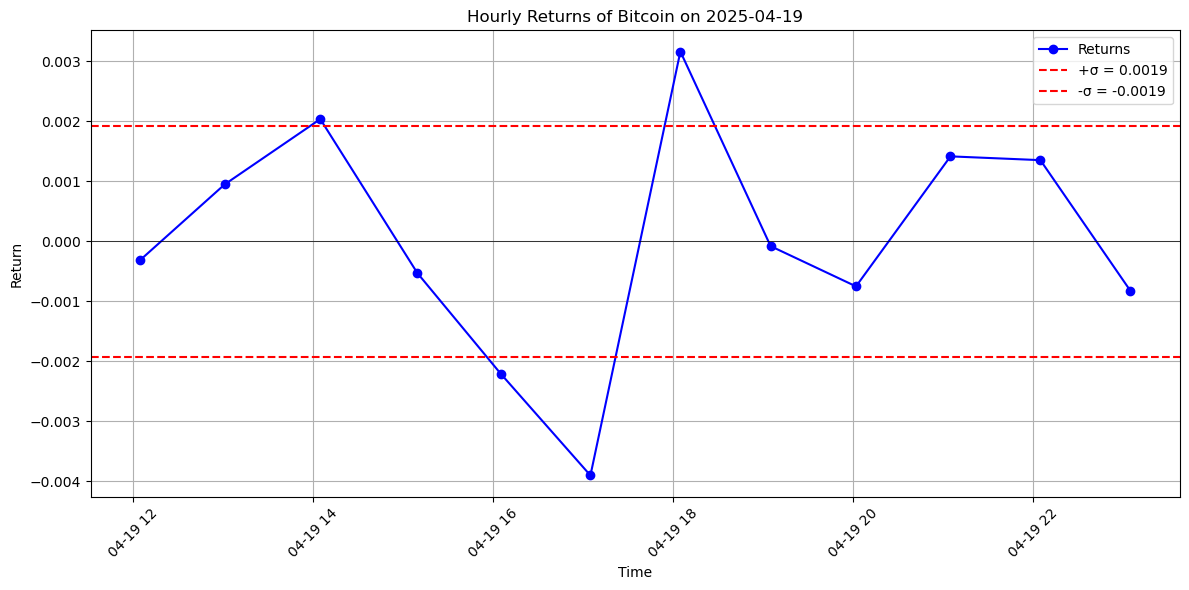

In [2]:
import matplotlib.pyplot as plt

url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"

params = {
    'vs_currency' : 'usd',
    'days' : '2', # set 2 days to analyse actually only one to escape error about free version
}

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}

response = requests.get(url, params=params, headers=headers)
data = response.json()
#print(data)
prices = pd.DataFrame(data['prices'],columns=['timestamp','price']) 

prices['timestamp'] = pd.to_datetime(prices['timestamp'], unit = 'ms')
prices.set_index('timestamp', inplace = True)

day_to_analyse = pd.to_datetime('2025-04-19') # set one date
next_day = day_to_analyse + pd.Timedelta(days=1) # set the second day
prices = prices[(prices.index >= day_to_analyse) & (prices.index < next_day)] # extract only one of these to to analyse one day hourly(default)

prices['return'] = prices['price'].pct_change() # calculate the percentage change from hour to hour (returns)

volatility = prices['return'].std() # calculate standard deviation of these returns (volatility)

print(prices)
print(f'Volatility of Bitcoin for last 24 hours:{volatility:.4f}')

prices['price'].plot(title=f'BTC Hourly Price on {day_to_analyse.date()}', figsize=(10,5))  # visualising price
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

prices['return'].plot(title=f'BTC Hourly Returns on {day_to_analyse.date()}',figsize=(10,5)) #visualising returns
plt.xlabel('Time')
plt.ylabel('Return')
plt.grid(True)
plt.show()
print(f'Votatility or Standard Deviation for 24h : {volatility:4f}')



plt.figure(figsize=(12, 6))
# Returns
plt.plot(prices.index, prices['return'], marker='o', linestyle='-', color='blue', label='Returns')

# adding standard deviation
plt.axhline(y=volatility, color='red', linestyle='--', label=f'+σ = {volatility:.4f}')
plt.axhline(y=-volatility, color='red', linestyle='--', label=f'-σ = {-volatility:.4f}')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.title('Hourly Returns of Bitcoin on 2025-04-19')
plt.xlabel('Time')
plt.ylabel('Return')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




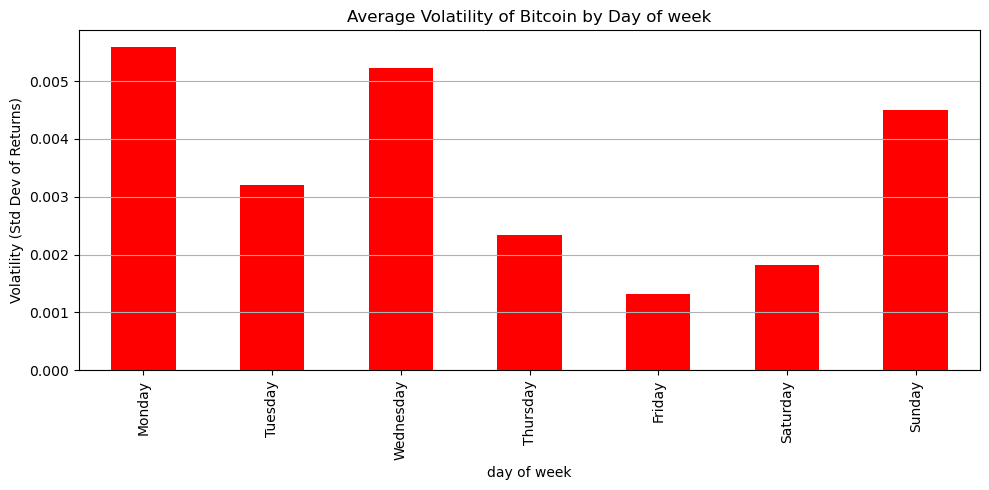

In [3]:
#Weekly Volatility 

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

results = [] 

for i in range(1,8):  # loop to analyse every day hourly from selected (today-n) days until today
    day = datetime.today() - timedelta(days=i) 
    next_day = day + timedelta(days=1)

    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
     'vs_currency' : 'usd',
      'days' : '7', # by changing days dont forget to change the loop too
    }

    headers = {
     "accept": "application/json",
     "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
    }

    response = requests.get(url, params=params, headers=headers)
    data = response.json()
    #print(data)

    prices = pd.DataFrame(data['prices'],columns=['timestamp','price']) 
    prices['timestamp'] = pd.to_datetime(prices['timestamp'], unit = 'ms')
    prices.set_index('timestamp', inplace = True)

    daily = prices[(prices.index >= day) & (prices.index < next_day)] #new list with prices by day
    daily= daily.copy()
    daily['return'] = daily['price'].pct_change() # calculating hourly returns for every day
    volatility = daily['return'].std() # calculating std dev for every day in week
    results.append({ # adding result to new the empty list
       'date': day.date(),
       'weekday' : day.strftime('%A'),
       'volatility' : volatility
    })

df = pd.DataFrame(results) 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['weekday'],categories=weekday_order, ordered=True) #set right order of weekdays (default alphabetical order)
#print(df)
grouped = df.groupby('weekday', observed=True)['volatility'].mean() # group calculated average of std devs by weekday
#print(grouped)

plt.figure(figsize=(10,5))
grouped.plot(kind='bar', color='red')
plt.title('Average Volatility of Bitcoin by Day of week')
plt.xlabel('day of week')
plt.ylabel('Volatility (Std Dev of Returns)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


                                price    return
timestamp                                      
2025-04-19 11:04:51.582  85222.967731       NaN
2025-04-19 12:04:38.460  85196.357248 -0.000312
2025-04-19 13:00:52.596  85277.070944  0.000947
2025-04-19 14:04:39.991  85450.837626  0.002038
2025-04-19 15:09:26.840  85405.397795 -0.000532
2025-04-19 16:04:54.075  85216.925511 -0.002207
2025-04-19 17:04:48.535  84884.074762 -0.003906
2025-04-19 18:04:47.543  85152.684142  0.003164
2025-04-19 19:04:57.549  85145.761088 -0.000081
2025-04-19 20:01:54.415  85081.679481 -0.000753
2025-04-19 21:04:53.819  85202.135263  0.001416
2025-04-19 22:04:51.622  85317.397984  0.001353
2025-04-19 23:04:56.247  85246.712841 -0.000828
Volatility of Bitcoin for last 24 hours:0.0019


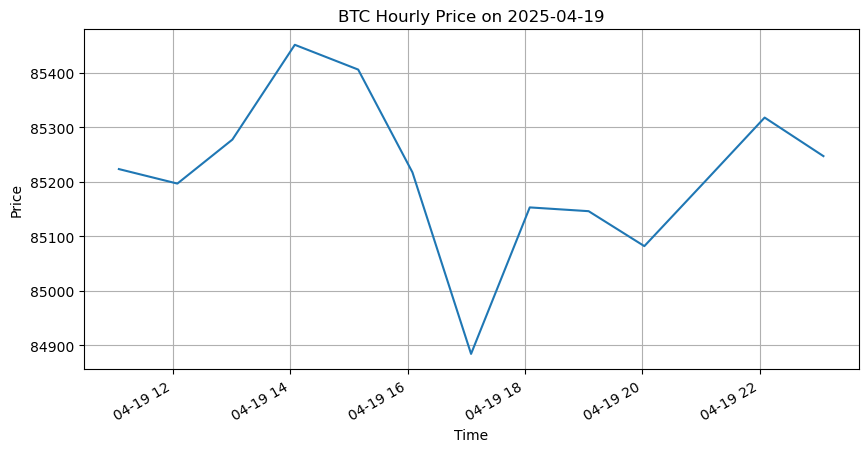

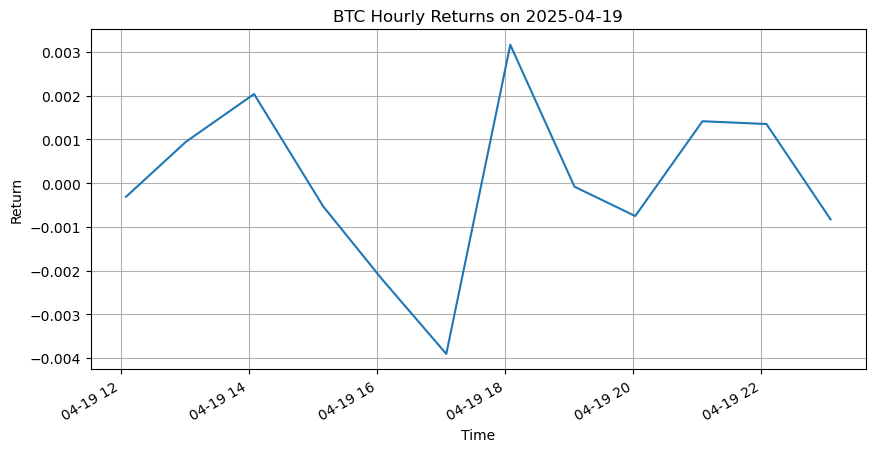

Votatility or Standard Deviation for 24h : 0.001923


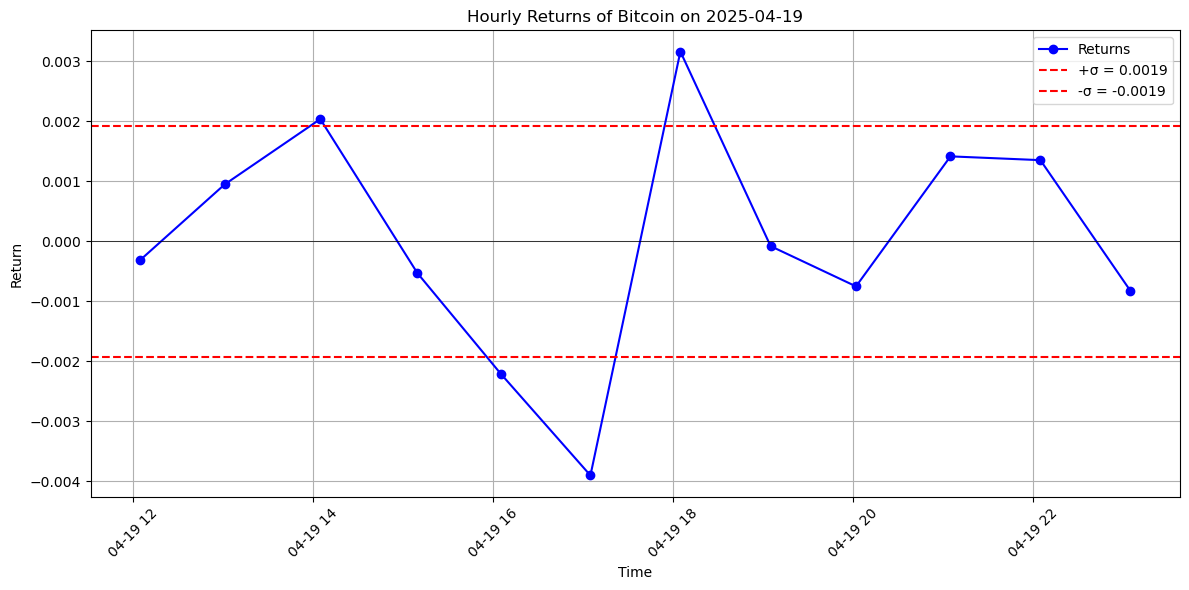

In [4]:
import matplotlib.pyplot as plt

url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"

params = {
    'vs_currency' : 'usd',
    'days' : '2', # set 2 days to analyse actually only one to escape error about free version
}

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}

response = requests.get(url, params=params, headers=headers)
data = response.json()
#print(data)
prices = pd.DataFrame(data['prices'],columns=['timestamp','price']) 

prices['timestamp'] = pd.to_datetime(prices['timestamp'], unit = 'ms')
prices.set_index('timestamp', inplace = True)

day_to_analyse = pd.to_datetime('2025-04-19') # set one date
next_day = day_to_analyse + pd.Timedelta(days=1) # set the second day
prices = prices[(prices.index >= day_to_analyse) & (prices.index < next_day)] # extract only one of these to to analyse one day hourly(default)

prices['return'] = prices['price'].pct_change() # calculate the percentage change from hour to hour (returns)

volatility = prices['return'].std() # calculate standard deviation of these returns (volatility)

print(prices)
print(f'Volatility of Bitcoin for last 24 hours:{volatility:.4f}')

prices['price'].plot(title=f'BTC Hourly Price on {day_to_analyse.date()}', figsize=(10,5))  # visualising price
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

prices['return'].plot(title=f'BTC Hourly Returns on {day_to_analyse.date()}',figsize=(10,5)) #visualising returns
plt.xlabel('Time')
plt.ylabel('Return')
plt.grid(True)
plt.show()
print(f'Votatility or Standard Deviation for 24h : {volatility:4f}')



plt.figure(figsize=(12, 6))
# Returns
plt.plot(prices.index, prices['return'], marker='o', linestyle='-', color='blue', label='Returns')

# adding standard deviation
plt.axhline(y=volatility, color='red', linestyle='--', label=f'+σ = {volatility:.4f}')
plt.axhline(y=-volatility, color='red', linestyle='--', label=f'-σ = {-volatility:.4f}')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.title('Hourly Returns of Bitcoin on 2025-04-19')
plt.xlabel('Time')
plt.ylabel('Return')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




                         total_volume
timestamp                            
2025-04-19 11:04:51.582  1.062014e+10
2025-04-19 12:04:38.460  1.071035e+10
2025-04-19 13:00:52.596  1.066041e+10
2025-04-19 14:04:39.991  1.084292e+10
2025-04-19 15:09:26.840  1.079403e+10
2025-04-19 16:04:54.075  1.178499e+10
2025-04-19 17:04:48.535  1.235323e+10
2025-04-19 18:04:47.543  1.284756e+10
2025-04-19 19:04:57.549  1.304748e+10
2025-04-19 20:01:54.415  1.287291e+10
2025-04-19 21:04:53.819  1.286995e+10
2025-04-19 22:04:51.622  1.286819e+10
2025-04-19 23:04:56.247  1.273128e+10


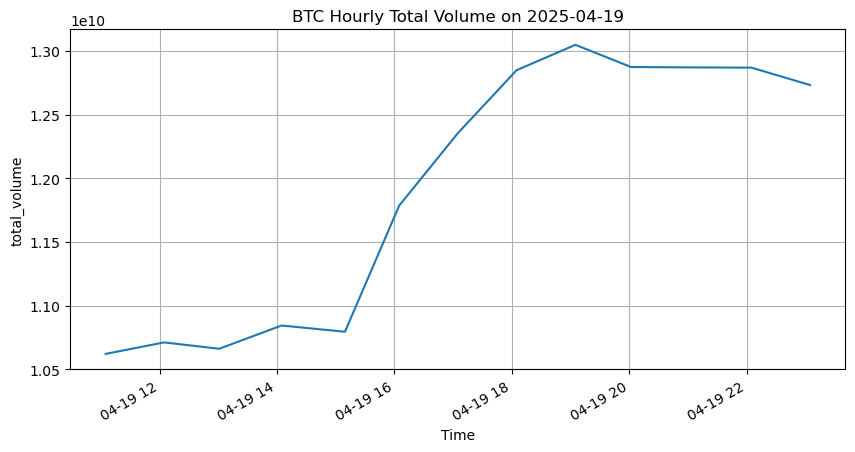

In [5]:
#Hourly Total Volume

import matplotlib.pyplot as plt

url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"

params = {
    'vs_currency' : 'usd',
    'days' : '2', # set 2 days to analyse actually only one to escape error about free version possibilities
}

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}

response = requests.get(url, params=params, headers=headers)
data = response.json()
#print(data)
total_volumes = pd.DataFrame(data['total_volumes'],columns=['timestamp','total_volume']) 

total_volumes['timestamp'] = pd.to_datetime(total_volumes['timestamp'], unit = 'ms')
total_volumes.set_index('timestamp', inplace = True)

day_to_analyse = pd.to_datetime('2025-04-19') # set one date
next_day = day_to_analyse + pd.Timedelta(days=1) # set the second day
total_volumes = total_volumes[(total_volumes.index >= day_to_analyse) & (total_volumes.index < next_day)] 

print(total_volumes)

total_volumes['total_volume'].plot(title=f'BTC Hourly Total Volume on {day_to_analyse.date()}', figsize=(10,5))  # visualising price
plt.xlabel('Time')
plt.ylabel('total_volume')
plt.grid(True)
plt.show()


                         total_volume
timestamp                            
2025-04-14 11:06:33.757  3.084892e+10
2025-04-14 12:07:53.170  3.083925e+10
2025-04-14 13:04:51.736  3.098833e+10
2025-04-14 14:04:54.942  3.122722e+10
2025-04-14 15:02:20.879  3.249641e+10
...                               ...
2025-04-21 07:03:21.837  2.310225e+10
2025-04-21 08:04:39.700  2.391733e+10
2025-04-21 09:09:32.608  2.443677e+10
2025-04-21 10:04:26.878  2.478065e+10
2025-04-21 10:39:19.000  2.492789e+10

[169 rows x 1 columns]


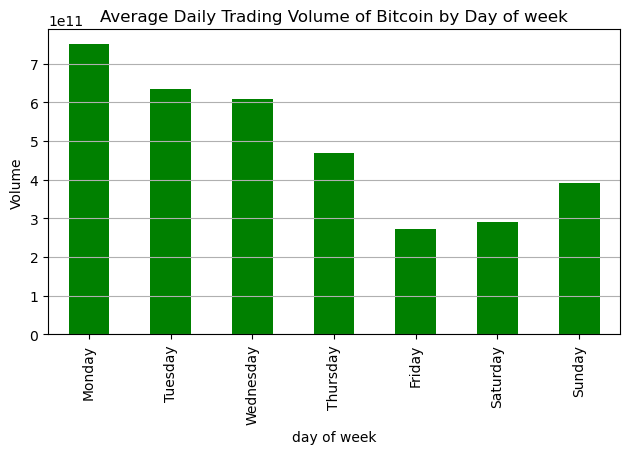

In [6]:
#Weekly Total Volume

import matplotlib.pyplot as plt

url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"

params = {
    'vs_currency' : 'usd',
    'days' : '7', # set 2 days to analyse actually only one to escape error about free version possibilities
}

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}

response = requests.get(url, params=params, headers=headers)
data = response.json()
#print(data)
total_volumes = pd.DataFrame(data['total_volumes'],columns=['timestamp','total_volume']) 

total_volumes['timestamp'] = pd.to_datetime(total_volumes['timestamp'], unit = 'ms')
total_volumes.set_index('timestamp', inplace = True)
print(total_volumes)

results = [] 
for i in range(1,8):
   day = datetime.today() - timedelta(days=i)
   next_day = day + timedelta(days=1)

   daily = total_volumes[(total_volumes.index >= day) & (total_volumes.index < next_day)] #new list with total_volumes by day
   daily= daily.copy()
   avg_volume = daily['total_volume'].sum() # calculating std dev for every day in week
   results.append({ # adding result to new the empty list
       'date': day.date(),
       'weekday' : day.strftime('%A'),
       'volume' : avg_volume
    })

df = pd.DataFrame(results) 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['weekday'],categories=weekday_order, ordered=True) #set right order of weekdays (default alphabetical order)
grouped = df.groupby('weekday', observed=True)['volume'].mean() # group calculated average of std devs by weekday

grouped.plot(kind='bar', color='green')
plt.title('Average Daily Trading Volume of Bitcoin by Day of week')
plt.xlabel('day of week')
plt.ylabel('Volume')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Correlation: 0.7741305487885453


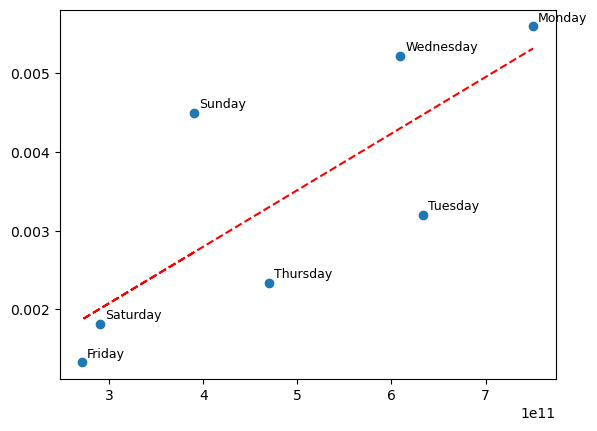

In [7]:
#Ratio of Volume and Volatility

import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

results_vl = [] 

for i in range(1,8):  # loop to analyse every day hourly from selected (today-n) days until today
    day = datetime.today() - timedelta(days=i) 
    next_day = day + timedelta(days=1)

    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
     'vs_currency' : 'usd',
      'days' : '7', # by changing days dont forget to change the loop too
    }

    headers = {
     "accept": "application/json",
     "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
    }

    response = requests.get(url, params=params, headers=headers)
    data = response.json()
    #print(data)

    prices = pd.DataFrame(data['prices'],columns=['timestamp','price']) 
    prices['timestamp'] = pd.to_datetime(prices['timestamp'], unit = 'ms')
    prices.set_index('timestamp', inplace = True)

    daily_vl = prices[(prices.index >= day) & (prices.index < next_day)] #new list with prices by day
    daily_vl= daily_vl.copy()
    daily_vl['return'] = daily_vl['price'].pct_change() # calculating hourly returns for every day
    volatility = daily_vl['return'].std() # calculating std dev for every day in week
    results_vl.append({ # adding result to new the empty list
       'date': day.date(),
       'weekday' : day.strftime('%A'),
       'volatility' : volatility
    })

df_vl = pd.DataFrame(results_vl) 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_vl['weekday'] = pd.Categorical(df_vl['weekday'],categories=weekday_order, ordered=True) #set right order of weekdays (default alphabetical order)
grouped_vl = df_vl.groupby('weekday', observed=True)['volatility'].mean() # group calculated average of std devs by weekday



total_volumes = pd.DataFrame(data['total_volumes'],columns=['timestamp','total_volume']) 
total_volumes['timestamp'] = pd.to_datetime(total_volumes['timestamp'], unit = 'ms')
total_volumes.set_index('timestamp', inplace = True)

results_tv = [] 
for i in range(1,8):
   day = datetime.today() - timedelta(days=i)
   next_day = day + timedelta(days=1)

   daily_tv = total_volumes[(total_volumes.index >= day) & (total_volumes.index < next_day)] #new list with total_volumes by day
   daily_tv= daily_tv.copy()
   avg_volume = daily_tv['total_volume'].sum() # calculating std dev for every day in week
   results_tv.append({ # adding result to new the empty list
       'date': day.date(),
       'weekday' : day.strftime('%A'),
       'volume' : avg_volume
    })

df_tv = pd.DataFrame(results_tv) 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_tv['weekday'] = pd.Categorical(df_tv['weekday'],categories=weekday_order, ordered=True) #set right order of weekdays (default alphabetical order)
grouped_tv = df_tv.groupby('weekday', observed=True)['volume'].mean() # group calculated average of std devs by weekday

df_combined = pd.merge(df_tv[['date', 'volume', 'weekday']], df_vl[['date', 'volatility']], on='date')
plt.scatter(df_combined['volume'], df_combined['volatility'])
corr = df_combined['volume'].corr(df_combined['volatility'])
m,b = np.polyfit(df_combined['volume'],df_combined['volatility'],1)
plt.plot(df_combined['volume'], m*df_combined['volume'] +b,color='red', linestyle='--')
for i, row in df_combined.iterrows():
    plt.annotate(row['weekday'], (row['volume'], row['volatility']), fontsize=9, xytext=(5,5),textcoords='offset pixels')
print(f'Correlation: {corr}')


                  timestamp  total_volume weekday  hour
0   2025-04-14 11:06:33.757  3.084892e+10  Monday    11
1   2025-04-14 12:07:53.170  3.083925e+10  Monday    12
2   2025-04-14 13:04:51.736  3.098833e+10  Monday    13
3   2025-04-14 14:04:54.942  3.122722e+10  Monday    14
4   2025-04-14 15:02:20.879  3.249641e+10  Monday    15
..                      ...           ...     ...   ...
164 2025-04-21 07:03:21.837  2.310225e+10  Monday     7
165 2025-04-21 08:04:39.700  2.391733e+10  Monday     8
166 2025-04-21 09:09:32.608  2.443677e+10  Monday     9
167 2025-04-21 10:04:26.878  2.478065e+10  Monday    10
168 2025-04-21 10:39:19.000  2.492789e+10  Monday    10

[169 rows x 4 columns]


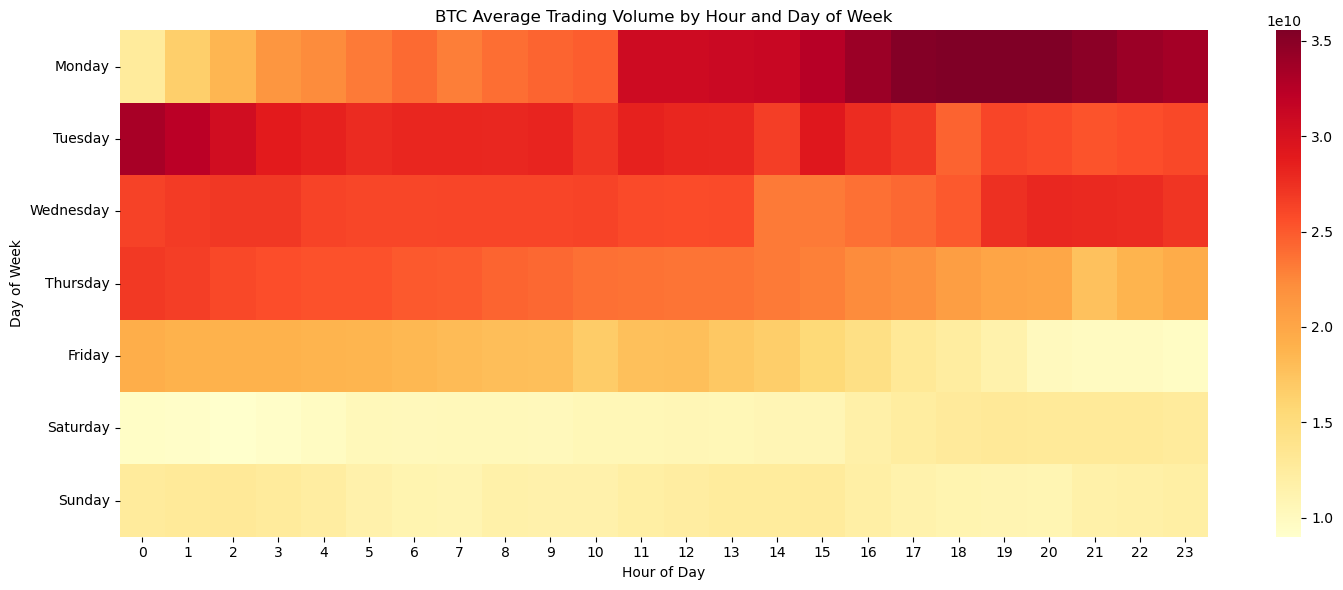

In [ ]:
#heatmap volume by hour and weekday

import seaborn as sns

url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"

params = {
    'vs_currency' : 'usd',
    'days' : '7',
}

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}

response = requests.get(url, params=params, headers=headers)
data = response.json()
#print(data)
df_volume = pd.DataFrame(data['total_volumes'],columns=['timestamp','total_volume']) 
df_volume['timestamp'] = pd.to_datetime(df_volume['timestamp'], unit = 'ms')
df_volume['weekday'] = df_volume['timestamp'].dt.day_name()
df_volume['hour'] = df_volume['timestamp'].dt.hour
#total_volumes.set_index('timestamp', inplace = True)
print(df_volume)

pivot_table = df_volume.pivot_table(index='weekday',columns='hour', values='total_volume', aggfunc='mean')

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(weekday_order)

plt.figure(figsize=(15,6))
sns.heatmap(pivot_table, cmap='YlOrRd')
plt.title('BTC Average Trading Volume by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()



hour       0         1         2         3         4         5         6   \
weekday                                                                     
Monday    NaN  0.006448  0.006547  0.007628  0.004380  0.002478  0.005466   
Tuesday   NaN  0.006551  0.014280  0.006287  0.003175  0.001126  0.002737   
Wednesday NaN  0.004345  0.006621  0.005472  0.003852  0.012235  0.004714   
Thursday  NaN  0.004467  0.000115  0.000952  0.001480  0.002553  0.002072   
Friday    NaN  0.003063  0.007796  0.002697  0.004312  0.001610  0.000545   
Saturday  NaN  0.000688  0.002331  0.004410  0.000171  0.000646  0.000670   
Sunday    NaN  0.000997  0.002242  0.000494  0.002326  0.006681  0.000475   

hour             7         8         9   ...        14        15        16  \
weekday                                  ...                                 
Monday     0.001012  0.000525  0.000137  ...  0.016617  0.002749  0.005266   
Tuesday    0.001962  0.001732  0.004035  ...  0.000957  0.005760  0.0005

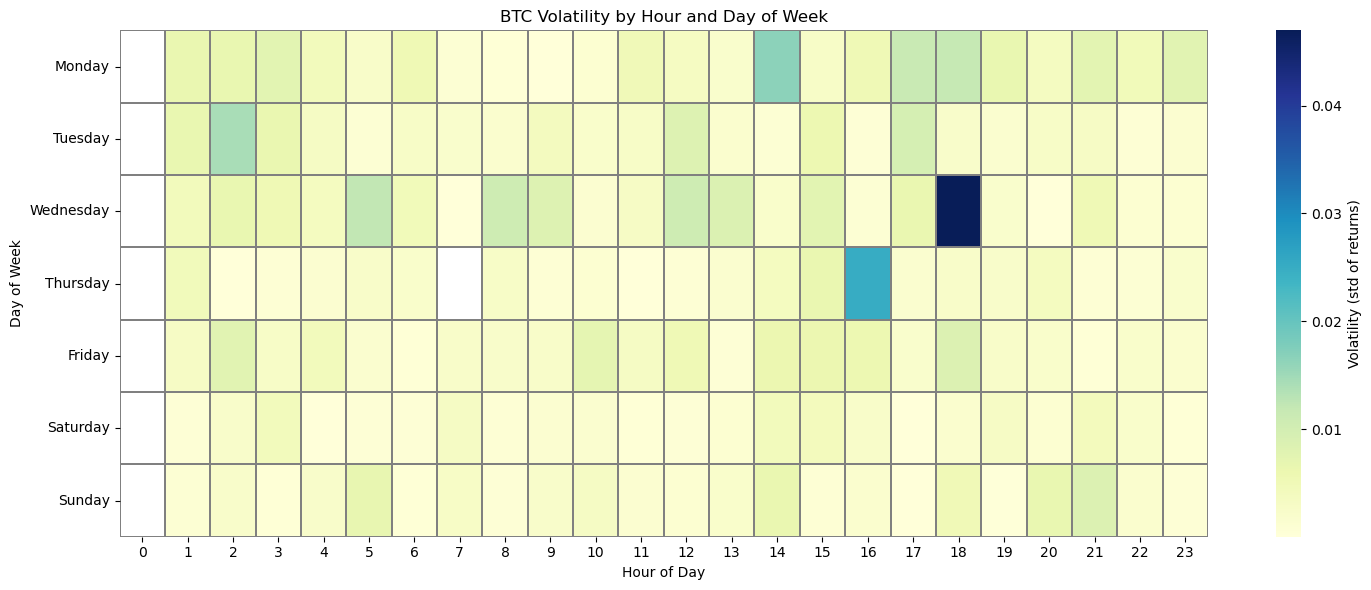

In [ ]:
#heatmap volatility by hour and weekday

url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"

params = {
    'vs_currency' : 'usd',
    'days' : '14',
}

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}

response = requests.get(url, params=params, headers=headers)
data = response.json()
    #print(data)

df_volat = pd.DataFrame(data['prices'],columns=['timestamp','price']) 
df_volat['timestamp'] = pd.to_datetime(df_volat['timestamp'], unit = 'ms')
df_volat['weekday'] = df_volat['timestamp'].dt.day_name()
df_volat['hour'] = df_volat['timestamp'].dt.hour
df_volat.set_index('timestamp', inplace = True)

df_volat['date'] = df_volat.index.date
df_volat['return'] = df_volat.groupby('date')['price'].pct_change()
#df_volat['return'] = df_volat['price'].pct_change() # calculating hourly returns for every day
#df_volat.to_csv('data')
vol_table = df_volat.groupby(['weekday','hour'])['return'].std().unstack()
#vol_table.to_csv('vol_table_not_unstack')
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
vol_table= vol_table.reindex(weekday_order) #set right order of weekdays (default alphabetical order)
print(vol_table)
plt.figure(figsize=(15,6))
sns.heatmap(vol_table, cmap='YlGnBu', annot=False, linewidths=0.3,linecolor='gray', cbar_kws={'label':'Volatility (std of returns)'})
plt.title('BTC Volatility by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

In [12]:
plt.savefig('graphic.png')
df.to_csv('data_csv.csv')
df_combined.to_json('data_json.json')

<Figure size 640x480 with 0 Axes>

                                 price  weekday  hour        date
timestamp                                                        
2025-01-21 12:01:10.436  103680.996946  Tuesday    12  2025-01-21
2025-01-21 13:03:51.018  104383.967044  Tuesday    13  2025-01-21
2025-01-21 14:08:24.633  104476.607038  Tuesday    14  2025-01-21
2025-01-21 15:03:44.899  103459.591110  Tuesday    15  2025-01-21
2025-01-21 16:06:29.188  104071.020141  Tuesday    16  2025-01-21
...                                ...      ...   ...         ...
2025-04-21 08:04:39.700   87446.144183   Monday     8  2025-04-21
2025-04-21 09:09:32.608   87636.206007   Monday     9  2025-04-21
2025-04-21 10:04:26.878   87491.963871   Monday    10  2025-04-21
2025-04-21 11:04:03.285   87345.612976   Monday    11  2025-04-21
2025-04-21 11:26:35.000   86871.988097   Monday    11  2025-04-21

[2159 rows x 4 columns]
                                 price  weekday  hour        date    return
timestamp                                

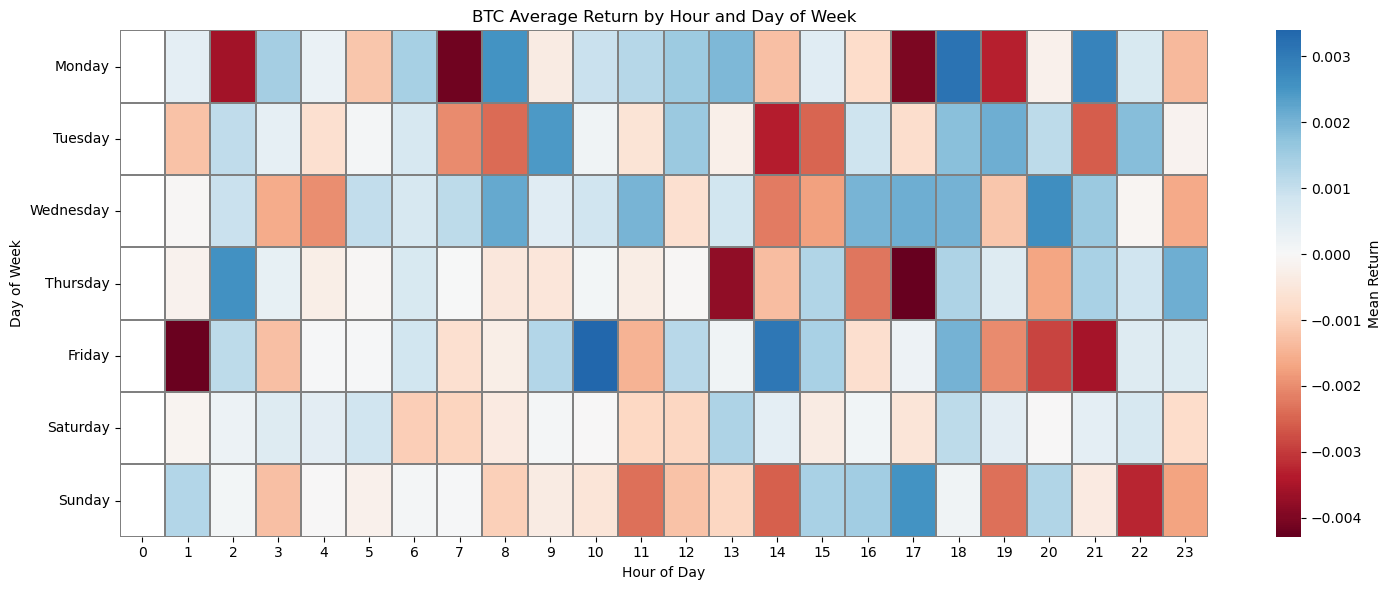

In [46]:
#heatmap returns by hour and weekday

url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"

params = {
    'vs_currency' : 'usd',
    'days' : '90',
}

headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}

response = requests.get(url, params=params, headers=headers)
data = response.json()
    #print(data)

df_ret = pd.DataFrame(data['prices'],columns=['timestamp','price']) 
df_ret['timestamp'] = pd.to_datetime(df_ret['timestamp'], unit = 'ms')
df_ret.set_index('timestamp', inplace = True)

df_ret['weekday'] = df_ret.index.day_name()
df_ret['hour'] = df_ret.index.hour
df_ret['date'] = df_ret.index.date
print(df_ret)
df_ret['return'] = df_ret.groupby('date')['price'].pct_change()
print(df_ret)
returns_table= df_ret.groupby(['weekday','hour'])['return'].mean().unstack()

print(returns_table)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
returns_table= returns_table.reindex(weekday_order) #set right order of weekdays (default alphabetical order)
returns_table.to_csv('avg_hourly_returns')
plt.figure(figsize=(15,6))
sns.heatmap(returns_table, cmap='RdBu',center=0, annot=False, linewidths=0.3,linecolor='gray', cbar_kws={'label':'Mean Return'})
plt.title('BTC Average Return by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

                                price
timestamp                            
2025-04-20 00:04:53.780  85089.159781
2025-04-20 01:04:39.515  85136.601774
2025-04-20 02:04:32.423  85279.665185
2025-04-20 03:04:45.251  85234.993919
2025-04-20 04:04:13.788  85143.828499
2025-04-20 05:01:40.936  85195.672595
2025-04-20 06:01:18.578  85100.822792
2025-04-20 07:04:37.355  84950.900731
2025-04-20 08:04:51.704  84777.376134
2025-04-20 09:04:14.804  84631.436866
2025-04-20 10:04:43.986  84530.865839
2025-04-20 11:04:51.487  84160.544909
2025-04-20 12:04:46.210  84093.833676
2025-04-20 13:04:47.251  84347.364384
2025-04-20 14:04:30.800  84327.789442
2025-04-20 15:04:40.110  84612.566423
2025-04-20 16:04:44.724  84357.124867
2025-04-20 17:04:34.686  84598.168647
2025-04-20 18:04:48.198  84563.859429
2025-04-20 19:04:44.699  84561.238706
2025-04-20 20:04:45.731  84633.096311
2025-04-20 21:04:41.938  85074.930148
2025-04-20 22:04:19.496  85006.658394
2025-04-20 23:04:46.701  84832.447383
            

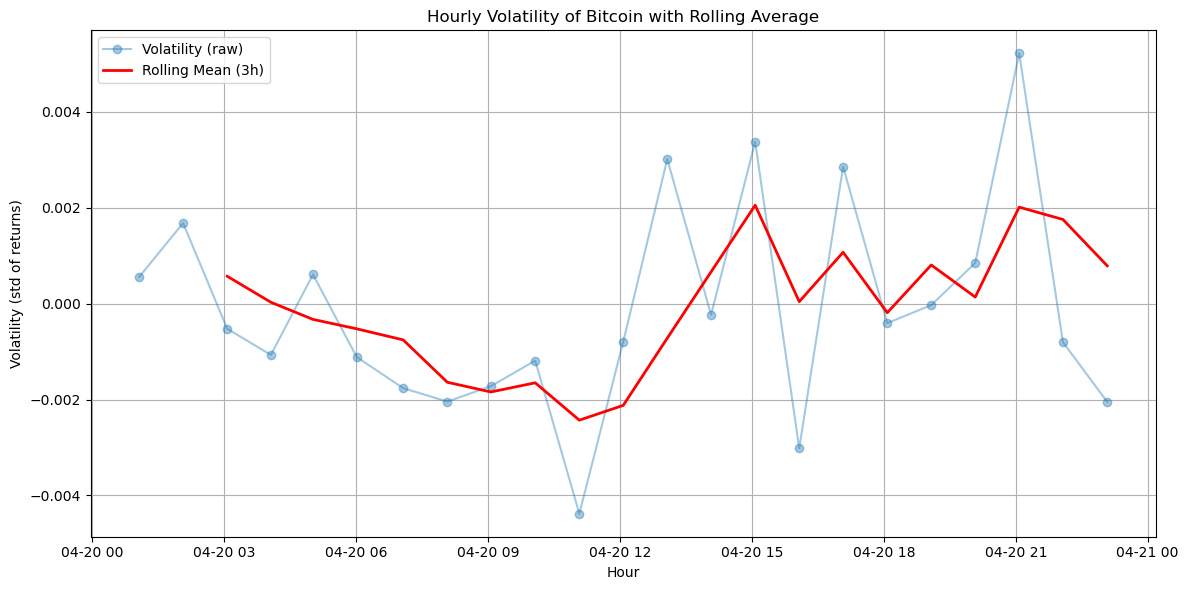

In [ ]:

url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {
    'vs_currency': 'usd',
    'days': '2'
}
headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}

response = requests.get(url, params=params, headers=headers)
data = response.json()

df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)


yesterday = pd.Timestamp.today().normalize() - pd.Timedelta(days=1) #make analyse only for one day (here for yesterday)
today = pd.Timestamp.today().normalize()
df_day = df[(df.index >= yesterday) & (df.index < today)].copy()

#print(df_day)

df_day['return'] = df_day['price'].pct_change()
#print(df_day)
df_day['vol'] = df_day['return'].std()
#print(df_day)

df_day['rolling_vol'] = df_day['return'].rolling(window=3).mean() #creating moving average with window 3

plt.figure(figsize=(12, 6))
plt.plot(df_day.index, df_day['return'], label='Volatility (raw)', marker='o', alpha=0.4)
plt.plot(df_day.index, df_day['rolling_vol'], label='Rolling Mean (3h)', color='red', linewidth=2)
plt.title('Hourly Volatility of Bitcoin with Rolling Average')
plt.xlabel('Hour')
plt.ylabel('Volatility (std of returns)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


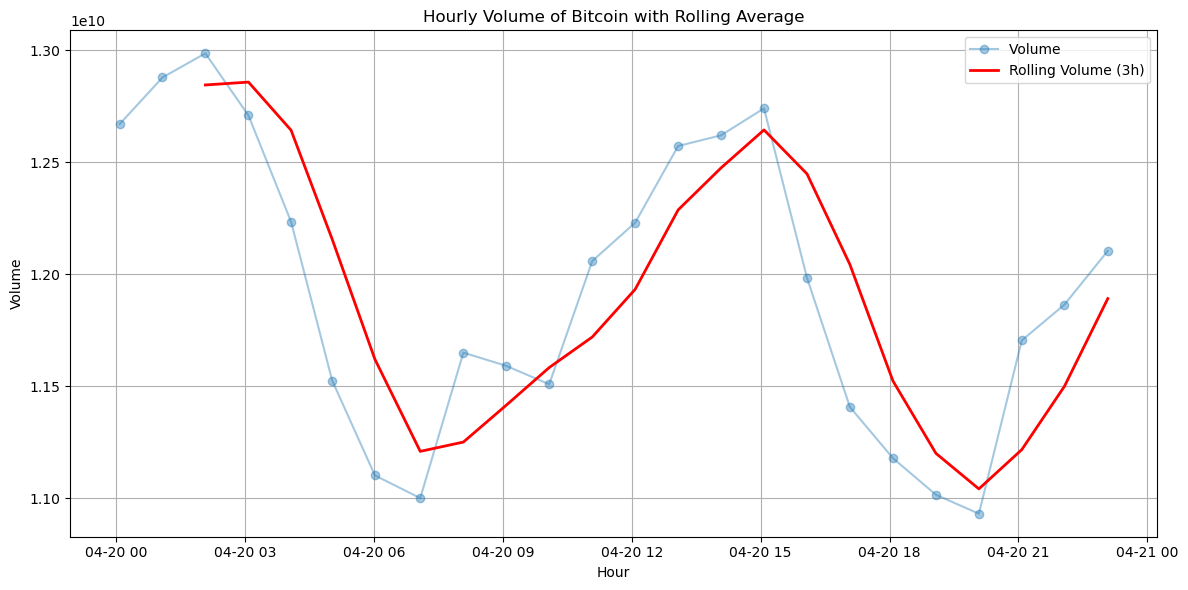

In [ ]:

url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {
    'vs_currency': 'usd',
    'days': '2'
}
headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}

response = requests.get(url, params=params, headers=headers)
data = response.json()

df = pd.DataFrame(data['total_volumes'], columns=['timestamp', 'total_volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)


yesterday = pd.Timestamp.today().normalize() - pd.Timedelta(days=1) #make analyse only for one day (here for yesterday)
today = pd.Timestamp.today().normalize()
df_day = df[(df.index >= yesterday) & (df.index < today)].copy()
#print(df_day)
df_day['rolling_volume'] = df_day['total_volume'].rolling(window=3).mean() #creating moving average with window 3
#print(df_day)

plt.figure(figsize=(12, 6))
plt.plot(df_day.index, df_day['total_volume'], label='Volume ', marker='o', alpha=0.4)
plt.plot(df_day.index, df_day['rolling_volume'], label='Rolling Volume (3h)', color='red', linewidth=2)
plt.title('Hourly Volume of Bitcoin with Rolling Average')
plt.xlabel('Hour')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

                         total_volume  rolling_volume
timestamp                                            
2025-04-20 00:04:53.780  1.267074e+10             NaN
2025-04-20 01:04:39.515  1.287881e+10             NaN
2025-04-20 02:04:32.423  1.298652e+10             NaN
2025-04-20 03:04:45.251  1.270912e+10             NaN
2025-04-20 04:04:13.788  1.223455e+10             NaN
2025-04-20 05:01:40.936  1.152526e+10             NaN
2025-04-20 06:01:18.578  1.110188e+10             NaN
2025-04-20 07:04:37.355  1.100045e+10             NaN
2025-04-20 08:04:51.704  1.165005e+10             NaN
2025-04-20 09:04:14.804  1.159161e+10             NaN
2025-04-20 10:04:43.986  1.150892e+10             NaN
2025-04-20 11:04:51.487  1.205914e+10             NaN
2025-04-20 12:04:46.210  1.223043e+10             NaN
2025-04-20 13:04:47.251  1.257281e+10             NaN
2025-04-20 14:04:30.800  1.262026e+10             NaN
2025-04-20 15:04:40.110  1.274083e+10             NaN
2025-04-20 16:04:44.724  1.1

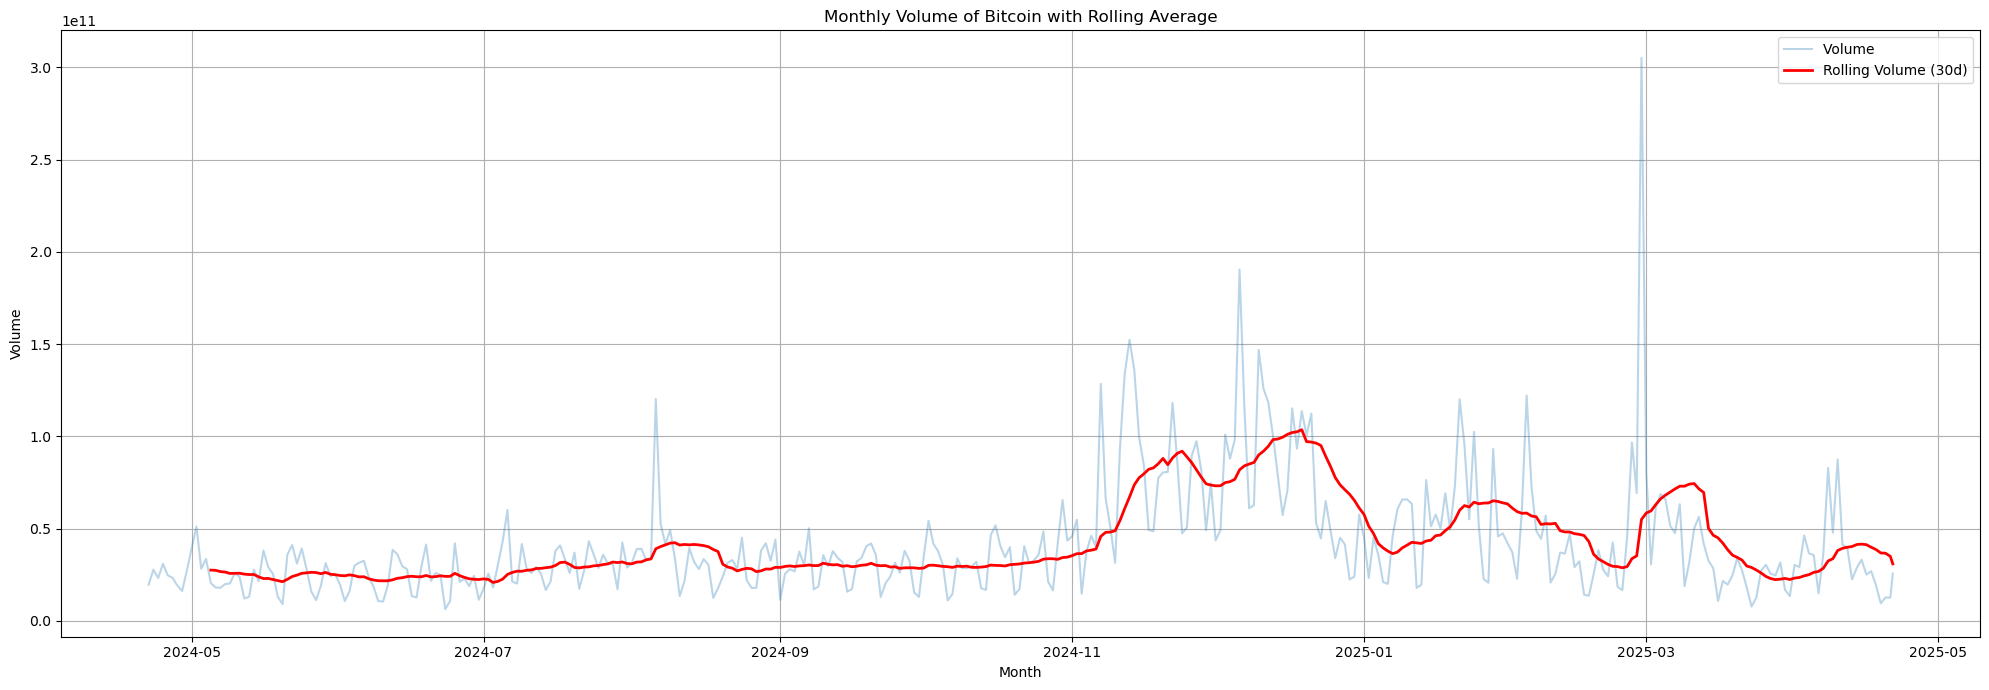

In [63]:

url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {
    'vs_currency': 'usd',
    'days': '365'
}
headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": "CG-XNGBRE1zynSYLPRSQhjN7n2v"
}

response = requests.get(url, params=params, headers=headers)
data = response.json()

df_year = pd.DataFrame(data['total_volumes'], columns=['timestamp', 'total_volume'])
df_year['timestamp'] = pd.to_datetime(df_year['timestamp'], unit='ms')
df_year.set_index('timestamp', inplace=True)

#print(df_year)
df_year['rolling_volume'] = df_year['total_volume'].rolling(window=14).mean() #creating moving average with window 3
df_year['log_volume'] = np.log1p(df_year['total_volume'])
df_year['rolling_log_volume'] = df_year['log_volume'].rolling(window=14).mean()
print(df_day)

plt.figure(figsize=(20, 7))
plt.plot(df_year.index, df_year['total_volume'], label='Volume ', alpha=0.3)
plt.plot(df_year.index, df_year['rolling_volume'], label='Rolling Volume (30d)', color='red', linewidth=2)
plt.title('Monthly Volume of Bitcoin with Rolling Average')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()